### Project Notes

* Airlines are in trouble and customers are "up for grabs". 

EDA Options

    * drop more outliers for Departure Delay?
    * check distributions of travel type, gender, class
    * do I want to bin age group data?
    * log transformations for highly skewed data?

* Bias in dataset? more likely to take survey if satisfied/dissatisfied?

    * Do I have an imbalanced data set? ---SLIGHTLY
        * Accuracy versus recall/precision

* Precision or recall?
    * care more about getting dissatisfied customers correct?
    * more expensive to lose a customers
    * customer churn/dissatisfaction
    * how much to lose a customer? 
    * lifetime value of an airline customer
    * Create a business case for losing customer/risk

    * goal: be sure to collect highest number of actually dissastisfied
        * precision: capturing dissatisfied, maximize actually dissatisfied (more scrutinous)
        * recall: make call happy passengers, grab as many dissatisfieds, even if some aren't dissatisfied (don't care about false positive)
        * May just want a model that performs well over threshold

Will eventually use ROC curve to compare algorithms (make decisions one level removed from model through graph).

In [493]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2 as pg

from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification
from scipy.spatial.distance import euclidean as euc
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
#from visualize import generate_moons_df, preprocess, plot_boundaries


In [494]:
connection_args = {
    'host': 'localhost',  # We are connecting to our _local_ version of psql
    'dbname': 'airline_passenger_data',    # DB that we are connecting to
    'port': 5432          # port we opened on AWS
}

connection = pg.connect(**connection_args) 

query = "SELECT * FROM survey_data1;"

df = pd.read_sql(query, connection)

In [495]:
#clean column names
df.columns=df.columns.str.strip().str.title().str.replace('_', ' ')

In [499]:
df = df.drop(columns = ['Col'])

In [500]:
df.head()

,Id,Gender,Customer Type,Age,Type Of Travel,Class,Flight Distance,Inflight Wifi Service,Dep Arr Time Convenience,Ease Of Online Booking,...,Inflight Entertainment,Onboard Service,Leg Room Service,Baggage Handling,Checkin Service,Inflight Service,Cleanliness,Departure Delay In Minutes,Arrival Delay In Minutes,Satisfaction
0,19556,Female,Loyal Customer,52,Business travel,Eco,160,5,4,3,...,5,5,5,5,2,5,5,50,44.0,satisfied
1,90035,Female,Loyal Customer,36,Business travel,Business,2863,1,1,3,...,4,4,4,4,3,4,5,0,0.0,satisfied
2,12360,Male,disloyal Customer,20,Business travel,Eco,192,2,0,2,...,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied
3,77959,Male,Loyal Customer,44,Business travel,Business,3377,0,0,0,...,1,1,1,1,3,1,4,0,6.0,satisfied
4,36875,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,4,...,2,2,2,2,4,2,4,0,20.0,satisfied


In [502]:
#adding CSVs and concatting dataframes
# df_kaggle1 = pd.read_csv("/Users/Tara8082/GIT/ProjectGIT/Project_3/train.csv", index_col = 'Unnamed: 0')
# df_kaggle2 = pd.read_csv("/Users/Tara8082/GIT/ProjectGIT/Project_3/test.csv",  index_col = 'Unnamed: 0')
# frames = [df_kaggle1, df_kaggle2]
# df = pd.concat(frames)

In [503]:
df.head(3)

,Id,Gender,Customer Type,Age,Type Of Travel,Class,Flight Distance,Inflight Wifi Service,Dep Arr Time Convenience,Ease Of Online Booking,...,Inflight Entertainment,Onboard Service,Leg Room Service,Baggage Handling,Checkin Service,Inflight Service,Cleanliness,Departure Delay In Minutes,Arrival Delay In Minutes,Satisfaction
0,19556,Female,Loyal Customer,52,Business travel,Eco,160,5,4,3,...,5,5,5,5,2,5,5,50,44.0,satisfied
1,90035,Female,Loyal Customer,36,Business travel,Business,2863,1,1,3,...,4,4,4,4,3,4,5,0,0.0,satisfied
2,12360,Male,disloyal Customer,20,Business travel,Eco,192,2,0,2,...,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied


In [505]:
# check for null values and drop 'Arrival Delay in Minutes' null values

df.isnull().sum()
df = df.dropna(subset = ['Arrival Delay In Minutes'])    

In [506]:
#129,487 customer record rows
#24 total columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129487 entries, 0 to 129879
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   Id                          129487 non-null  object
 1   Gender                      129487 non-null  object
 2   Customer Type               129487 non-null  object
 3   Age                         129487 non-null  object
 4   Type Of Travel              129487 non-null  object
 5   Class                       129487 non-null  object
 6   Flight Distance             129487 non-null  object
 7   Inflight Wifi Service       129487 non-null  object
 8   Dep Arr Time Convenience    129487 non-null  object
 9   Ease Of Online Booking      129487 non-null  object
 10  Gate Location               129487 non-null  object
 11  Food And Drink              129487 non-null  object
 12  Online Boarding             129487 non-null  object
 13  Seat Comfort                1

In [507]:
df['Departure Delay In Minutes'].describe()

count     129487
unique       464
top            0
freq       73209
Name: Departure Delay In Minutes, dtype: object

In [519]:
df.dtypes

Id                            object
Gender                        object
Customer Type                 object
Age                           object
Type Of Travel                object
Class                         object
Flight Distance               object
Inflight Wifi Service         object
Dep Arr Time Convenience      object
Ease Of Online Booking        object
Gate Location                 object
Food And Drink                object
Online Boarding               object
Seat Comfort                  object
Inflight Entertainment        object
Onboard Service               object
Leg Room Service              object
Baggage Handling              object
Checkin Service               object
Inflight Service              object
Cleanliness                   object
Departure Delay In Minutes     int64
Arrival Delay In Minutes      object
Satisfaction                  object
dtype: object

In [524]:
df["Age"] = df["Age"].astype(str).astype(int)
df["Flight Distance"] = df["Flight Distance"].astype(str).astype(int)
df["Inflight Wifi Service"] = df["Inflight Wifi Service"].astype(str).astype(int)
df["Dep Arr Time Convenience"] = df["Dep Arr Time Convenience"].astype(str).astype(int)
df["Ease Of Online Booking"] = df["Ease Of Online Booking"].astype(str).astype(int)
df["Gate Location"] = df["Gate Location"].astype(str).astype(int)
df["Food And Drink"] = df["Food And Drink"].astype(str).astype(int)
df["Online Boarding"] = df["Online Boarding"].astype(str).astype(int)
df["Leg Room Service"] = df["Leg Room Service"].astype(str).astype(int)
df["Checkin Service"] = df["Checkin Service"].astype(str).astype(int)
df["Inflight Service"] = df["Inflight Service"].astype(str).astype(int)
df["Cleanliness"] = df["Cleanliness"].astype(str).astype(int)
df["Departure Delay In Minutes"] = df["Departure Delay In Minutes"].astype(str).astype(int)

In [525]:
delay_std = round(np.std(df['Departure Delay In Minutes']), 2)
delay_mean = round(df['Departure Delay In Minutes'].mean(), 2)
print('STD departure delay (minutes):', + delay_std)
print('Mean departure delay (minutes):', + delay_mean)

STD departure delay (minutes): 37.93
Mean departure delay (minutes): 14.64


## Should I remove outliers for Departure Delay in Minutes?

In [526]:
import numpy as np
import matplotlib.pyplot as plt
# seed(1)

# multiply and add by random numbers to get some real values
data = df['Departure Delay In Minutes']

#define list to accumulate anomalies
anomalies = []
# Function to Detection Outlier on one-dimentional datasets.
def find_anomalies(data):
    
    
    # Set upper and lower limit to 3 standard deviation
    random_data_std = np.std(data)
    random_data_mean = np.mean(data)
    anomaly_cut_off = random_data_std * 3
    
    lower_limit  = random_data_mean - anomaly_cut_off 
    upper_limit = random_data_mean + anomaly_cut_off
    print(lower_limit, ": lower limit")
    print(upper_limit, ": upper limit")
    # Generate outliers
    for outlier in data:
        if outlier > upper_limit or outlier < lower_limit:
            anomalies.append(outlier)
    print(len(anomalies), 'is the number of outliers.')
    return anomalies

find_anomalies(data)

-99.1547751767204 : lower limit
128.44154527719382 : upper limit
2716 is the number of outliers.


[180,
 168,
 243,
 152,
 238,
 150,
 141,
 132,
 132,
 140,
 214,
 145,
 277,
 129,
 493,
 332,
 136,
 416,
 137,
 187,
 247,
 145,
 129,
 146,
 130,
 222,
 163,
 205,
 275,
 167,
 142,
 204,
 170,
 258,
 132,
 155,
 202,
 951,
 190,
 202,
 214,
 266,
 290,
 209,
 315,
 302,
 136,
 154,
 143,
 144,
 135,
 228,
 146,
 137,
 214,
 203,
 138,
 366,
 149,
 135,
 134,
 211,
 190,
 184,
 137,
 131,
 132,
 185,
 130,
 154,
 132,
 352,
 156,
 157,
 140,
 142,
 151,
 188,
 131,
 130,
 132,
 145,
 166,
 196,
 151,
 161,
 144,
 168,
 141,
 197,
 255,
 157,
 199,
 166,
 157,
 136,
 381,
 130,
 156,
 151,
 146,
 163,
 139,
 153,
 163,
 146,
 225,
 223,
 161,
 284,
 251,
 293,
 149,
 298,
 213,
 184,
 312,
 177,
 396,
 148,
 217,
 202,
 132,
 187,
 243,
 145,
 162,
 162,
 197,
 222,
 161,
 384,
 167,
 294,
 148,
 170,
 244,
 130,
 178,
 167,
 131,
 182,
 151,
 224,
 162,
 148,
 244,
 149,
 489,
 158,
 137,
 207,
 202,
 404,
 138,
 165,
 232,
 197,
 189,
 178,
 265,
 175,
 134,
 138,
 179,
 447,
 234

In [527]:
df = df[df['Departure Delay In Minutes'] <= 1000] 

In [528]:
#remove passengers under 12?

#df = df[df['Age'] >= 12]

In [529]:
df.shape

(129483, 24)

In [530]:
df.loc[(df['Customer Type'] == 'Loyal Customer'),'Customer Type']= str('Loyal')
df.loc[(df['Customer Type'] == 'disloyal Customer'),'Customer Type']= str('Disloyal')

## Exploratory Data Analysis

In [531]:
# Balance of dataset

# imbalance = a random oversampler (of minority class)
# should I cut some majority?

balance = df['Satisfaction'].value_counts('neutral or dissatisfied')
balance

neutral or dissatisfied    0.565503
satisfied                  0.434497
Name: Satisfaction, dtype: float64

### Correlations

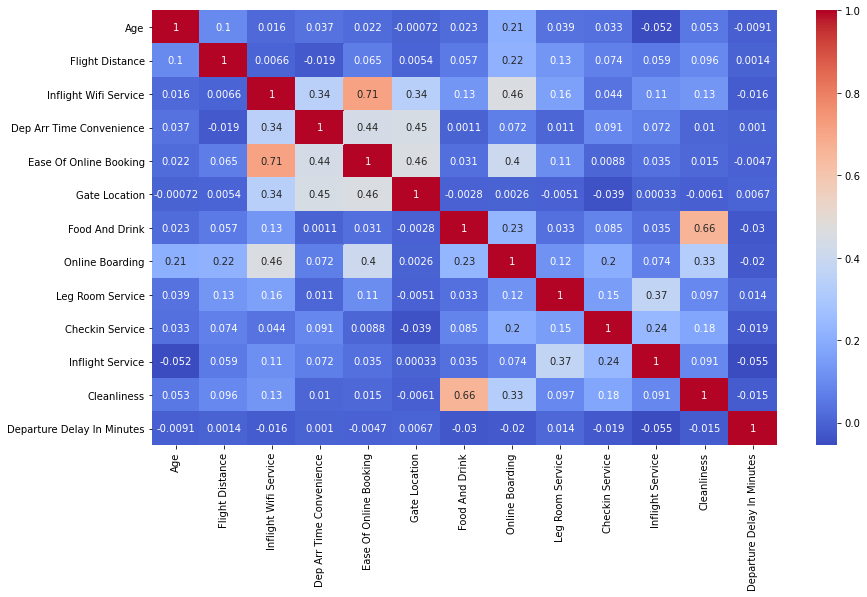

In [532]:
# drop arrival delay in minutes
# some may be highly correlated (high score) but not worth dropping yet until see how model performs

plt.figure(figsize=(14,8))
sns.heatmap(df.corr(), cmap= 'coolwarm', annot=True);

In [533]:
# drop as arrival and departure delay are co-linear

df = df.drop(['Arrival Delay In Minutes'], axis =1 )


### Distributions

Text(0, 0.5, 'Customers')

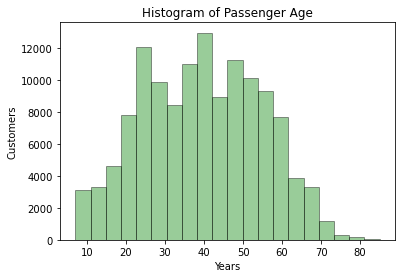

In [534]:
# Passenger Age Distribution
sns.distplot(df['Age'], hist=True, kde=False, 
             bins=int(100/5), color = 'green',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of Passenger Age')
plt.xlabel('Years')
plt.ylabel('Customers')

In [535]:
df['Gender'].value_counts()

Female    65702
Male      63781
Name: Gender, dtype: int64

Text(0.5, 1.0, 'Side-by-Side Histogram with Genders')

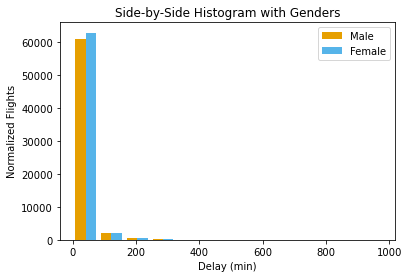

In [540]:
# Make a separate list for each gender
x1 = list(df[df['Gender'] == 'Male']['Departure Delay In Minutes'])
x2 = list(df[df['Gender'] == 'Female']['Departure Delay In Minutes'])


# Assign colors for each airline and the names
colors = ['#E69F00', '#56B4E9']
names = ['Male', 'Female']
         
# Make the histogram using a list of lists
# Normalize the flights and assign colors and names
plt.hist([x1, x2], bins = int(180/15), #normed=True,
         color = colors, label=names)

# Plot formatting
plt.legend()
plt.xlabel('Delay (min)')
plt.ylabel('Normalized Flights')
plt.title('Side-by-Side Histogram with Genders')

Text(0.5, 1.0, 'Side-by-Side Histogram with Class Types')

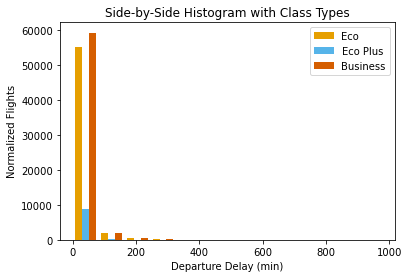

In [541]:
#Eco, Eco Plus, Business Class Hisotgram by Departure Delay in Minutes

# Make a separate list for each Class
x1 = list(df[df['Class'] == 'Eco']['Departure Delay In Minutes'])
x2 = list(df[df['Class'] == 'Eco Plus']['Departure Delay In Minutes'])
x3 = list(df[df['Class'] == 'Business']['Departure Delay In Minutes'])


# Assign colors for each airline and the names
colors = ['#E69F00', '#56B4E9', '#D55E00']
names = ['Eco', 'Eco Plus', 'Business']
         
# Make the histogram using a list of lists
# Normalize the flights and assign colors and names
plt.hist([x1, x2, x3], bins = int(180/15), #normed=True,
         color = colors, label=names)

# Plot formatting
plt.legend()
plt.xlabel('Departure Delay (min)')
plt.ylabel('Normalized Flights')
plt.title('Side-by-Side Histogram with Class Types')

In [542]:
df['Class'].value_counts()

Business    61988
Eco         58115
Eco Plus     9380
Name: Class, dtype: int64

Text(0.5, 1.0, 'Side-by-Side Histogram with Genders')

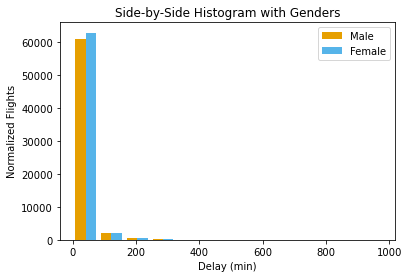

In [563]:
# Make a separate list for each gender
x1 = list(df[df['Gender'] == 'Male']['Departure Delay In Minutes'])
x2 = list(df[df['Gender'] == 'Female']['Departure Delay In Minutes'])


# Assign colors for each airline and the names
colors = ['#E69F00', '#56B4E9']
names = ['Male', 'Female']
         
# Make the histogram using a list of lists
# Normalize the flights and assign colors and names
plt.hist([x1, x2], bins = int(180/15), #normed=True,
         color = colors, label=names)

# Plot formatting
plt.legend()
plt.xlabel('Delay (min)')
plt.ylabel('Normalized Flights')
plt.title('Side-by-Side Histogram with Genders')

Text(0, 0.5, 'Flights')

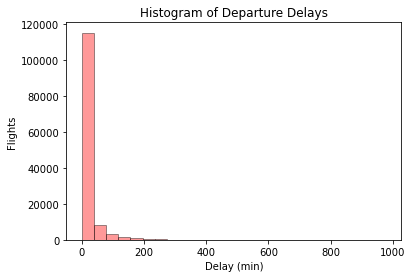

In [544]:
# Departure Delay Distribution
sns.distplot(df['Departure Delay In Minutes'], hist=True, kde=False, 
             bins=int(250/10), color = 'red',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of Departure Delays')
plt.xlabel('Delay (min)')
plt.ylabel('Flights')

In [545]:
df['Customer Type'].value_counts()

Loyal       105769
Disloyal     23714
Name: Customer Type, dtype: int64

Loyal       105769
Disloyal     23714
Name: Customer Type, dtype: int64

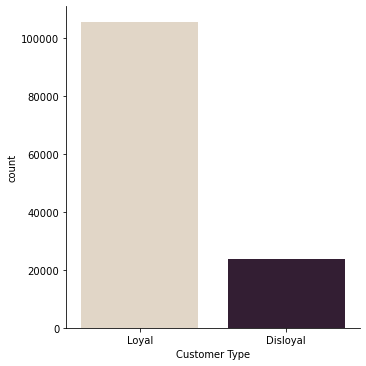

In [546]:
sns.catplot(x="Customer Type", kind="count", palette="ch:.25", data=df);
df["Customer Type"].value_counts()

In [547]:
# Make a separate list for each gender
x1 = list(df[df['Customer Type'] == 'Loyal']['Departure Delay In Minutes'])
x2 = list(df[df['Customer Type'] == 'Disloyal']['Departure Delay In Minutes'])


# Assign colors for each airline and the names
colors = ['#E69F00', '#56B4E9']
names = ['Loyal Customer', 'Disloyal Customer']
         
# Make the histogram using a list of lists
# Normalize the flights and assign colors and names
plt.hist([x1, x2], bins = int(250,10), normed=True,
         color = colors, label=names)

# Plot formatting
plt.legend()
plt.xlabel('Delay (min)')
plt.ylabel('Normalized Flights')
plt.title('Side-by-Side Histogram with Loyal v Disloyal Customers')

TypeError: int() can't convert non-string with explicit base

## Modeling

In [548]:
df_model = df.copy()

In [549]:
df_model.head(3)

,Id,Gender,Customer Type,Age,Type Of Travel,Class,Flight Distance,Inflight Wifi Service,Dep Arr Time Convenience,Ease Of Online Booking,...,Seat Comfort,Inflight Entertainment,Onboard Service,Leg Room Service,Baggage Handling,Checkin Service,Inflight Service,Cleanliness,Departure Delay In Minutes,Satisfaction
0,19556,Female,Loyal,52,Business travel,Eco,160,5,4,3,...,3,5,5,5,5,2,5,5,50,satisfied
1,90035,Female,Loyal,36,Business travel,Business,2863,1,1,3,...,5,4,4,4,4,3,4,5,0,satisfied
2,12360,Male,Disloyal,20,Business travel,Eco,192,2,0,2,...,2,2,4,1,3,2,2,2,0,neutral or dissatisfied


In [550]:
df_model['Satisfaction'] = df_model['Satisfaction'].apply(lambda x: 1 if x == 'neutral or dissatisfied' else 0)

In [555]:
features = ['Gender', 'Customer Type', 'Age', 'Type Of Travel', 'Class',
       'Flight Distance', 'Inflight Wifi Service', 'Dep Arr Time Convenience',
       'Ease Of Online Booking', 'Gate Location', 'Food And Drink',
       'Online Boarding', 'Seat Comfort', 'Inflight Entertainment',
       'Onboard Service', 'Leg Room Service', 'Baggage Handling',
       'Checkin Service', 'Inflight Service', 'Cleanliness',
       'Departure Delay In Minutes']

X = df_model[features]
y = df_model['Satisfaction']



In [556]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=6)

In [558]:
#specify categorical features

categoricals = ['Gender', 'Customer Type', 'Type Of Travel', 'Class']
non_cat = ['Flight Distance', 'Inflight Wifi Service',
       'Dep Arr Time Convenience', 'Ease Of Online Booking',
       'Gate Location', 'Food And Drink', 'Online Boarding', 'Seat Comfort',
       'Inflight Entertainment', 'Onboard Service', 'Leg Room Service',
       'Baggage Handling', 'Checkin Service', 'Inflight Service',
       'Cleanliness', 'Departure Delay In Minutes']

ohe = OneHotEncoder(sparse=False)

cat_matrix_train = ohe.fit_transform(X_train.loc[:, categoricals])

X_train_ohe = pd.DataFrame(cat_matrix_train,
                           columns=ohe.get_feature_names(categoricals), #create meaningful column names
                           index=X_train.index) #keep the same index values

#combine continuous and categorical data

X_train_preprocessed = pd.concat([X_train[non_cat], X_train_ohe], axis=1)

#Scale data
ss = StandardScaler()
X_train_preprocessed = ss.fit_transform(X_train_preprocessed) # X_train_preprocessed is a numpy array


In [559]:
# Create validation set with X_train_preprocessed data

X_train_scaled, X_val_scaled, y_train, y_val = train_test_split(X_train_preprocessed, y_train, test_size=.3, random_state=2)

In [560]:
#transform and scale testing set --- DON'T TOUCH TEST UNTIL END.

cat_matrix_test = ohe.transform(X_test.loc[:, categoricals]) #only transform on the test set!

X_test_ohe = pd.DataFrame(cat_matrix_test,
                           columns=ohe.get_feature_names(categoricals), #create meaningful column names
                           index=X_test.index) #keep the same index values

X_test_preprocessed = pd.concat([X_test[non_cat], X_test_ohe], axis=1)

#Scale test data
X_test_preprocessed = ss.transform(X_test_preprocessed)

In [561]:
# Logistic Regression Model on Train/Val data

lr = LogisticRegression(penalty='none')

lr.fit(X_train_scaled, y_train)

log_y_val_preds = lr.predict(X_val_scaled)

#test_preds = lr.predict(X_test_preprocessed) #DON'T RUN

print(classification_report(y_val, log_y_val_preds))

              precision    recall  f1-score   support

           0       0.87      0.84      0.86     11620
           1       0.88      0.91      0.90     15572

    accuracy                           0.88     27192
   macro avg       0.88      0.87      0.88     27192
weighted avg       0.88      0.88      0.88     27192



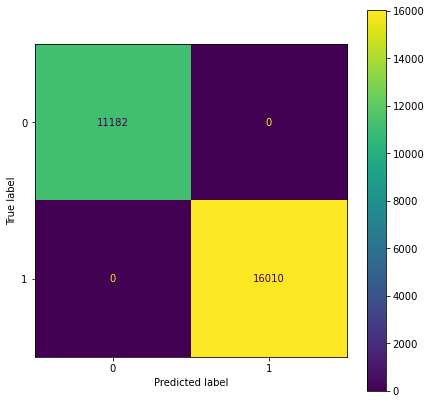

In [562]:
# Confusion Matrix

fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(lr, X_val_scaled, log_y_val_preds, ax=ax);

### K Nearest Neighbors

In [479]:
# What does this function do?

ks = range(15, 20) #range(1, 30)

test_errors = np.zeros(len(list(ks)))

for i,k in enumerate(ks):
    
    nn = KNeighborsClassifier(n_neighbors = k)

    nn.fit(X_train_scaled, y_train)
    test_k_preds = nn.predict(X_val_scaled)
    
    test_errors[i] = np.sqrt(mean_squared_error(y_val, test_k_preds))
    print(k, test_errors[i])

15 0.27941802672153765
16 0.27796649468647255
17 0.2820380374088831
18 0.28000966654183507
19 0.2825591242964096


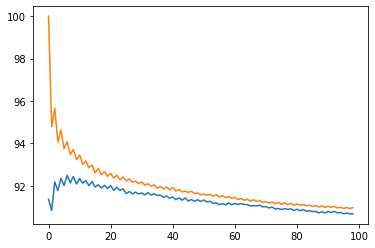

In [444]:
#looping through 100 ks to find optimal k (TOOK HOURS TO RUN)
test_scores = []
train_scores = []
for k in range(1,100):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    train_score = 100*knn.score(X_train_scaled, y_train)
    test_score = 100*knn.score(X_val_scaled, y_val)
    test_scores.append(test_score)
    train_scores.append(train_score)

plt.plot(test_scores)
plt.plot(train_scores)